In [1]:
from tf_util_y import *
from DP import DataLoader
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
d1 = DataLoader(data_name = "FFBC400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "all")
d2 = DataLoader(data_name = "RH400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "all")

In [39]:
class model5(MODEL):
    def __init__(self,name = "defmodel5"):
        MODEL.__init__(self,name)
        self.X = tf.placeholder(shape = [None,20,50,18],dtype = tf.float32)
        self.Y = tf.placeholder(shape = [None,3],dtype = tf.float32)
        
        self.S0 = CONV2D(self.X,[3,3,18,40],name = self.name + "S0")
        self.S1 = CONV2D(self.X,[1,50,18,50],name = self.name + "S1")
        self.S2 = CONV2D(self.X,[20,1,18,20],name = self.name + "S2")
        self.S3 = CONV2D(self.X,[5,5,18,40],name = self.name + "S3")
        
        self.AS0 = ACT(PLUSB(self.S0,name = self.name + "bAS0"),name = self.name + "AS0")
        self.AS1 = ACT(PLUSB(self.S1,name = self.name + "bAS1"),name = self.name + "AS1")
        self.AS2 = ACT(PLUSB(self.S2,name = self.name + "bAS2"),name = self.name + "AS2")
        self.AS3 = ACT(PLUSB(self.S3,name = self.name + "bAS3"),name = self.name + "AS3")
        
        self.Z0 = CONV2D(self.AS0,[5,5,40,60],name = self.name + "Z0")
        self.Z1 = tf.transpose(self.AS1,[0,1,3,2])
        self.Z2 = tf.transpose(self.AS2,[0,3,2,1])
        self.Z3 = CONV2D(self.AS3,[3,3,40,60],name = self.name + "Z3")
        
        self.CC0 = tf.concat([self.Z0,self.Z3],axis=3)
        self.CC1 = tf.concat([self.Z1,self.Z2],axis=3)
        
        self.ZCC0 = CONV2D(self.CC0,[1,1,120,90],name = self.name + "ZCC0")
        self.ZCC1 = CONV2D(self.CC1,[7,7,2,30],name = self.name + "ZCC1")
        
        self.ACC0 = ACT(PLUSB(self.ZCC0,name = self.name + "bACC0"),name = self.name + "ACC0")
        self.ACC1 = ACT(PLUSB(self.ZCC1,name = self.name + "bACC1"),name = self.name + "ACC1")
        
        self.C = tf.concat([self.ACC0,self.ACC1],axis = 3)
        
        self.P = tf.nn.max_pool(self.C,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
        
        self.ZP = CONV2D(self.P,[7,7,120,140],name = self.name + "ZP")
        self.AP = ACT(PLUSB(self.ZP,name = self.name + "bAP"),name = self.name +"AP")
        
        self.BNAP = BN(self.AP,name = self.name + "BNAP")
        self.ZZ = CONV2D(self.BNAP,[1,16,140,160],name = self.name + "ZZ")
        
        self.AZZ = ACT(PLUSB(self.ZZ,name = self.name + "bAZZ"),name = self.name + "AZZ")
        self.F = tf.contrib.layers.flatten(self.AZZ)
        self.ZF = FC(self.F,130,name = self.name+"ZF")
        self.AF = ACT(PLUSB(self.ZF,name = self.name + "bAF"),name = self.name + "AF")
        self.OUP = FC(self.AF,3,name = self.name+"OUP")
        
        self.cost = tf.reduce_mean(tf.squared_difference(100*self.OUP[1:3],100*self.Y[1:3]))
        self.opt = tf.train.AdadeltaOptimizer(30).minimize(self.cost)
        self.init = tf.global_variables_initializer()
        

In [41]:
tf.reset_default_graph()
m = model5()

In [42]:
m.open()

<IPython.core.display.Javascript object>


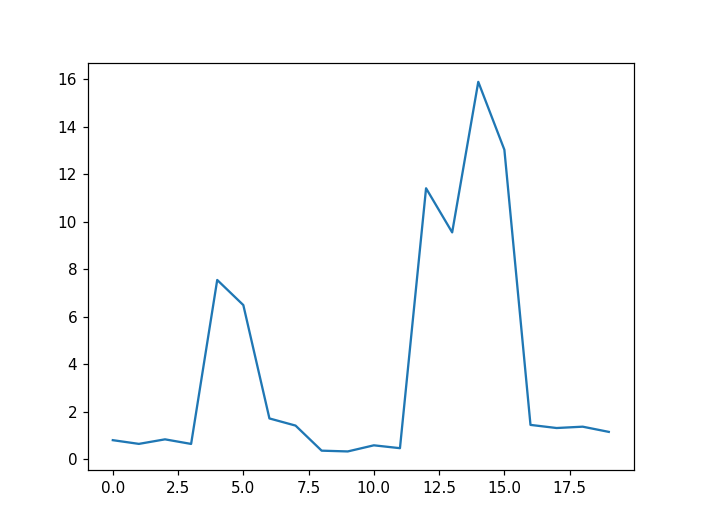

In [50]:
m.train_minib(d1["X_tr"],d1["Y_tr"],bloop=2,bsize=128,loop=10)

In [51]:
yy = m.sess.run(m.OUP,feed_dict={m.X:d1["X_te"][0:600]})
YY = d1["Y_te"][0:600]

In [52]:
abs(yy[:,0]-YY[:,0]).mean(),abs(yy[:,1]-YY[:,1]).mean(),abs(yy[:,2]-YY[:,2]).mean()

(0.016828058044895376, 0.013930178087316687, 0.014643695970978855)

In [53]:
(abs(yy[:,0]-YY[:,0])<0.01).sum()/len(yy), (abs(yy[:,1]-YY[:,1])<0.01).sum()/len(yy), (abs(yy[:,2]-YY[:,2])<0.01).sum()/len(yy)

(0.43833333333333335, 0.42166666666666669, 0.53500000000000003)

In [54]:
yy = m.sess.run(m.OUP,feed_dict={m.X:d2["X_te"]})
YY = d2["Y_te"]

In [55]:
abs(yy[:,0]-YY[:,0]).mean(),abs(yy[:,1]-YY[:,1]).mean(),abs(yy[:,2]-YY[:,2]).mean()

(0.022829493976290555, 0.017737486815327833, 0.016085060544593643)

In [56]:
(abs(yy[:,0]-YY[:,0])<0.01).sum()/len(yy), (abs(yy[:,1]-YY[:,1])<0.01).sum()/len(yy), (abs(yy[:,2]-YY[:,2])<0.01).sum()/len(yy)

(0.37575757575757573, 0.45454545454545453, 0.52121212121212124)

In [57]:
m.close()